<a href="https://colab.research.google.com/github/mizzonimirko/ADV_NN22-23/blob/main/Progect_Adversial_Attacks_for_free.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Networks 2022/2023
  Author : **Mirko Mizzoni** \\
 Id: **1841476** \\
 Master in *Control Engineering* \\
 This notebook implements *the algorithm 1* present on paper [1]


# Description
Adversarial training, in which a network is trained on adversarial examples, is one
of the few defenses against adversarial attacks that withstands strong attacks. Unfortunately, the high cost of generating strong adversarial examples makes standard
adversarial training impractical on large-scale problems like ImageNet. We present
an algorithm that eliminates the overhead cost of generating adversarial examples
by recycling the gradient information computed when updating model parameters.


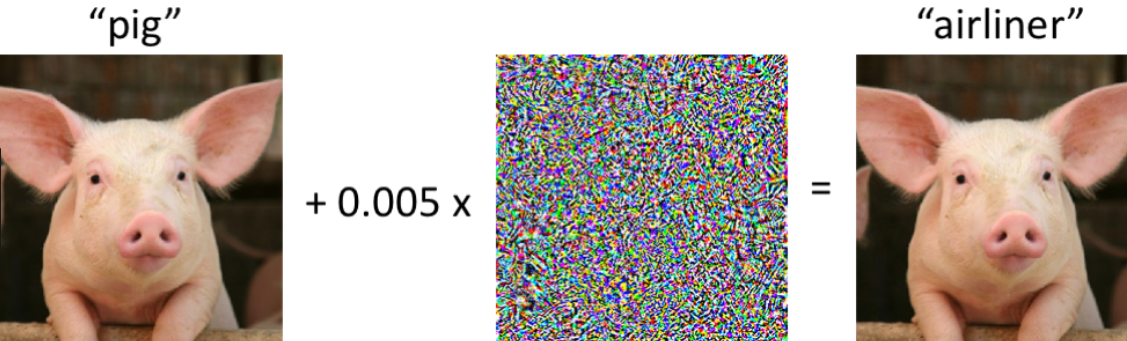

# The algorithm
This free adversarial training algorithm computes the ascent step by re-using
the backward pass needed for the descent step. To update the network parameters, the current training
minibatch is passed forward through the network. Then, the gradient with respect to the network
parameters is computed on the backward pass. When the “free” method is used, the gradient of the
loss with respect to the input image is also computed on this same backward pass. Unfortunately, this approach does not allow for multiple adversarial updates to be made to the same
image without performing multiple backward passes. To overcome this restriction, the authors propose a
minor yet nontrivial modification to training: train on the same minibatch $m$ times in a row. Note
that we divide by the number of epochs by $m$ such that the overall number of training iterations remains
constant.
# **I will exploit how strength is the network by performing several K-PGD attacks**
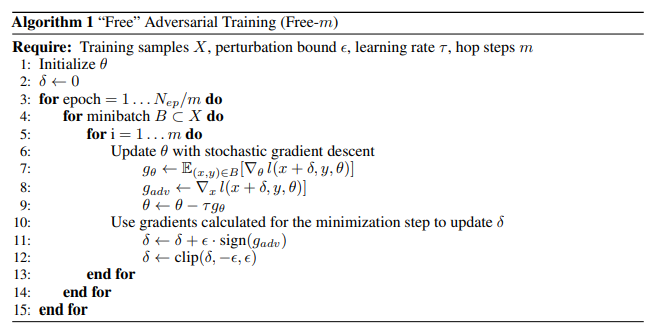

Some comments:
* They update both perturbation and network parameters in one pass
* They replay every mini-batch $m$ times to simulate PGD training

In [3]:
# @title Upload dependecies
%pip install torchmetrics --quiet
import torch
from torch import nn
import tqdm
import time
import torchvision
from tqdm import tqdm
from torch.nn import functional as F
import torchmetrics
from torch.utils.data import DataLoader
from torchvision import transforms as T
import matplotlib.pyplot as plt

torch.manual_seed(3407)        # Torch.manual_seed(3407) is all you need: On the influence of random seeds in deep learning architectures for computer vision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 9.5 MB/s eta 0:00:00


Loading the dataset


100%|██████████| 9912422/9912422 [00:00<00:00, 313887925.20it/s]

Extracting /data/MNIST/raw/train-images-idx3-ubyte.gz to /data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 64502499.37it/s]


Extracting /data/MNIST/raw/train-labels-idx1-ubyte.gz to /data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 93435264.35it/s]

Extracting /data/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 1352156.20it/s]


Extracting /data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/MNIST/raw

[TrainDataset] Length: 60000
[TrainDataset] Information about the dataset: Dataset MNIST
    Number of datapoints: 60000
    Root location: /data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
           )
[TestDataset] Length: 60000
[TestDataset] Information about the dataset: Dataset MNIST
    Number of datapoints: 60000
    Root location: /data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
           )
Corresponding label : 5
Corresponding image shape : torch.Size([1, 28, 28])


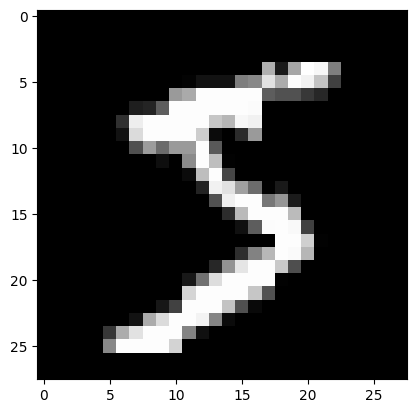

In [2]:
train_transforms = T.Compose([
    T.ToTensor(),              # to tensor
    T.RandomRotation(15),      # evert image will be rotated about of an angle btw [-15, +15]
    T.RandomHorizontalFlip()   # Horizontally flip the given image randomly with a default probability = 0.5.
])

print("Loading the dataset")
# @title Load the MNIST dataset
# training dataset
train_data = torchvision.datasets.MNIST('/data',train = True, download =True , transform = train_transforms)    # Traininig actual dataset - dataset object
print(f"[TrainDataset] Length: {len(train_data)}") # we have 60000 images
print(f"[TrainDataset] Information about the dataset: {train_data}")
# test dataset
test_data = torchvision.datasets.MNIST('/data',train = False, download =True , transform = T.ToTensor())    # Traininig actual dataset - dataset object
print(f"[TestDataset] Length: {len(train_data)}") # we have 60000 images
print(f"[TestDataset] Information about the dataset: {train_data}")
# Iterator
image,label = next(iter(train_data))
print(f"Corresponding label : {label}")
print(f"Corresponding image shape : {image.shape}")   # 1 channel, black and white, the channel dimension is the first dimension
# I plot the image
plt.imshow(image[0], cmap = 'gray')

We need some additional things to train it. We need to shuffle the dataset and to batch elements. We do not want to have a single image but a mini-batch of a certain number of elements. This is done by a dataloader which has ways of loading minibathes of data from our dataset

In [3]:
# @title Loader
print('Data Loader - - - ')
batch_size = 32
# the loader will provide a minibatches of images instead of 1 simple image
train_dataloader = DataLoader(train_data, batch_size=batch_size , shuffle=True)
batch_imgs,batch_lbls = next(iter(train_dataloader))
print('[TrainLoader] # of Batches ' , len(train_dataloader))
print('[TrainLoader] Batch of Images Shape' ,batch_imgs.shape)        # 64 black and white 28x28 images
print('[TrainLoader] Batch of Labels Shape' ,batch_lbls.shape)        # 64 labels
test_dataloader = DataLoader(test_data, batch_size=batch_size , shuffle=False)
batch_imgs_t,batch_lbls_t = next(iter(train_dataloader))
print('[TestLoader] # of Batches ' , len(test_dataloader))
print('[TestLoader] Batch of Images Shape' ,batch_imgs_t.shape)        # 64 black and white 28x28 images
print('[TestLoader] Batch of Labels Shape' ,batch_lbls_t.shape)        # 64 labels

Data Loader - - - 
[TrainLoader] # of Batches  1875
[TrainLoader] Batch of Images Shape torch.Size([32, 1, 28, 28])
[TrainLoader] Batch of Labels Shape torch.Size([32])
[TestLoader] # of Batches  313
[TestLoader] Batch of Images Shape torch.Size([32, 1, 28, 28])
[TestLoader] Batch of Labels Shape torch.Size([32])


In [4]:
# @title Neural Network - Model
class CNN (nn.Module):
  def __init__(self):
    super().__init__()
    self.cnn1 = nn.Conv2d(1, 16, 5, padding = 2)
    self.cnn2 = nn.Conv2d(16, 32 , 5, padding = 2)
    self.bn1 = nn.BatchNorm2d(16)
    self.bn2 = nn.BatchNorm2d(32)
    self.max_pool = nn.MaxPool2d(2)
    self.fc1 = nn.Linear(32*7*7,100)
    self.fc2 = nn.Linear(100,10)
    self.drop = nn.Dropout(0.2)
  def forward(self,x):
    x = F.relu(self.bn1(self.cnn1(x)))
    x = self.max_pool(x)
    x = F.relu(self.bn2(self.cnn2(x)))
    x = self.max_pool(x)
    x = x.reshape(-1,32*7*7)
    x = self.fc1(x)
    x = self.drop(F.relu(x))
    x = self.fc2(x)
    return x      #logits y = Wx

print('Sanity check ------------------------------------ ')
print('Initialization ...')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cnn = CNN().to(device)
batch_imgs = batch_imgs.to(device)
print('Test on our fist training batch : ',cnn(batch_imgs).shape)
print('# of Tensors of parameters :', len(list(cnn.parameters())))  # cnn.parameters() is an iterator over the parameters

Sanity check ------------------------------------ 
Initialization ...
Test on our fist training batch :  torch.Size([32, 10])
# of Tensors of parameters : 12


In [5]:
# @title Setup the Optimizer and the Loss
opt = torch.optim.Adam(cnn.parameters())
loss = nn.CrossEntropyLoss().to(device)                                        # it takes the logits

In [6]:
# @title Accuracy Function
def accuracy(x,device):
  acc = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)
  for xB,yB in test_dataloader:
    xB = xB.to(device)
    yB = yB.to(device)
    ypred= cnn(xB)
    l = loss(ypred, yB)
    _ = acc(ypred,yB)
  return acc.compute()

# With respect to Standard Adversarial Training (K-PGD)

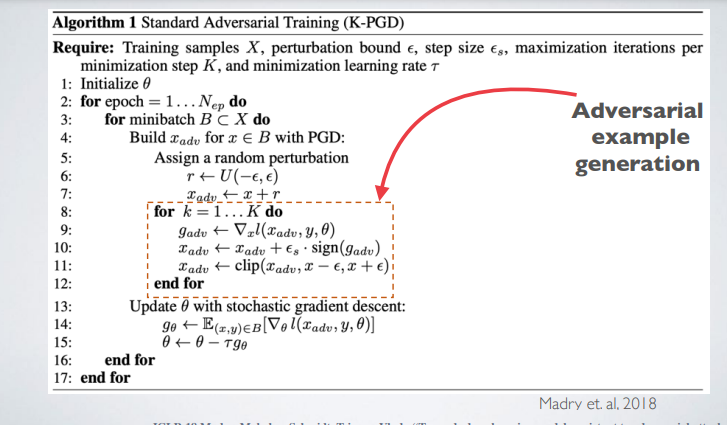

By using K-PGD adversarial training what we are doing is:
$\min_w \max_{\delta_i} \frac{1}{N} \sum_{i=1}^{N}J(w,\boldsymbol{x_i}+\delta_i)$
During these $K$ iterations no weight updates i.e. we perform an additional $K$
forward and backward passes without updating the network parameters \\
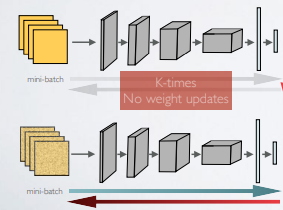


Unlike K-PGD training, I update the network parameters every time I do a back-ward pass! \\
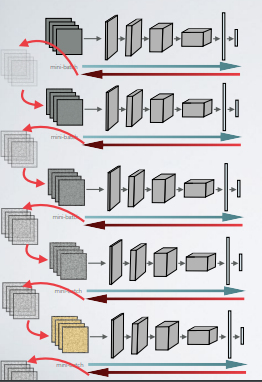

In [11]:
# This function has the aim of testing our model towards K-PGD Attacks
def acc_pgd(test_dataloader, model, criterion, K, step,eps):
    model.eval()
    acc = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)
    for xB,yB in test_dataloader:
        xB = xB.to(device)
        yB = yB.to(device)
        # I need a copy of the input for the algorithm (step 10-11-12)
        input = xB.clone()
        r = torch.FloatTensor(xB.size()).uniform_(-eps, eps).to(device)
        # Build xadv for x in B with PGD, Assign a random perturbation and add it
        xB = xB+ r
        # Clamp it in order to remain inside the set of admissible values
        xB.clamp_(0, 1.0)
        # Adversarial example generation
        for _ in range(K):
            i = torch.tensor(xB, requires_grad=True).to(device)
            pred = model(i)
            # Compute the a_loss l(xadv,y,theta) - (ascent loss)
            a_loss = criterion(pred, yB)
            # Compute the gradient with respect to the in-variable (ascent grad) -(g_adv)
            a_grad = torch.autograd.grad(a_loss, i)[0]
            # The perturbation will be step*sign(g_adv)
            pert = torch.sign(a_grad)*step
            # Apply purturbation
            xB = xB + pert.data
            # You have to clip now : xadv <-clip(xadv,x-eps,x+eps)
            xB = torch.max(input-eps, xB)
            xB = torch.min(input+eps, xB)
            # Clamp it in order to remain inside the set of admissible values
            xB.clamp_(0, 1.0)
        # Update theta with stochadtic gradient descent
        with torch.no_grad():
            # compute the predicted  output
            output = model(xB)
            # compute the loss
            loss = criterion(output, yB)
            # measure the accuracy
            _ = acc(output,yB)
    return acc.compute()

In [12]:
# Standard Adversarial Training (K-PGD)
def train_pgd(train_dataloader, model, criterion, K, step,eps):
    model.train()
    for xB,yB in train_dataloader:
        xB = xB.to(device)
        yB = yB.to(device)
        # I need a copy of the input for the algorithm (step 10-11-12)
        input = xB.clone()
        r = torch.FloatTensor(xB.size()).uniform_(-eps, eps).to(device)
        # Build xadv for x in B with PGD, Assign a random perturbation and add it
        xB = xB+ r
        # Clamp it in order to remain inside the set of admissible values
        xB.clamp_(0, 1.0)
        # Adversarial example generation
        for _ in range(K):
            i = torch.tensor(xB, requires_grad=True).to(device)
            pred = model(i)
            # Compute the a_loss l(xadv,y,theta) - (ascent loss)
            a_loss = criterion(pred, yB)
            # Compute the gradient with respect to the in-variable (ascent grad) -(g_adv)
            a_grad = torch.autograd.grad(a_loss, i)[0]
            # The perturbation will be step*sign(g_adv)
            pert = torch.sign(a_grad)*step
            # Apply purturbation
            xB = xB + pert.data
            # You have to clip now : xadv <-clip(xadv,x-eps,x+eps)
            xB = torch.max(input-eps, xB)
            xB = torch.min(input+eps, xB)
            # Clamp it in order to remain inside the set of admissible values
            xB.clamp_(0, 1.0)
        # Update theta with stochadtic gradient descent
        # compute the predicted  output
        output = model(xB)
        # compute the loss
        losS = criterion(output, yB)
        opt.zero_grad()
        losS.backward()
        opt.step()

For each $m$ , for each $K$, I will start retraining the neural network (it is a choice, for sure!)

In [9]:
# @title Core of the Algorithm
def train(model,m,eps,step):   # training function
    model.train()                     # set the net in train mode
    global gnd
    for xB,yB in train_dataloader:
        xB = xB.to(device)          # put the input batch into the GPU
        yB = yB.to(device)          # put the input batch into the GPU
        for _ in range(m):          # m is the replay parameter
          delta_batch = gnd[0:xB.size(0)].clone().detach().requires_grad_(True)
          # Update theta with stoschastic gradient descent
          gAdv = xB+delta_batch
          gAdv.clamp_(0,1.0)        # our inputs data must lie inside (0 , max([0,255])/255)
          outP = model(gAdv)          # forward pass with perturbed input
          l = loss( outP, yB)       # compute the loss
          # Zeroing the gradients
          opt.zero_grad()
          l.backward()
          opt.step()
          # Use gradients calculated for the minimization step to update δ
          pert = torch.sign(delta_batch.grad)*step
          gnd[0:xB.size(0)] = gnd[0:xB.size(0)]+ pert.data
          gnd.clamp_(-eps,eps)
    model.eval()
    return l

In [ ]:
# @title The algorithm
n_epochs = 10                                              # set number of epochs
#attackers_m = [1,2,4,8,16,32,64,200]                      # a list of different replay params
attackers_m = [5,200]                                          # a list of different replay params
Ks  = [7,20]
accuracies = []                                            # accuracies vector
LossDict = {}
eps = 0.1
step = 0.1
gnd = torch.zeros(batch_size, 1, 28, 28).to(device)       # a memory on our last delta
for m in attackers_m:
  for K in Ks:
    print(f"Replay Parameter : m = {m} , {K} PGD- Attack : , # of epochs : {n_epochs}")
    # Re-inizialiation procedure - - - - - - --
    gnd = torch.zeros(batch_size, 1, 28, 28).to(device)       # a memory on our last delta
    # - - - - - - - - - - - - - - - -  -
    Loss = 0.0
    cnn  = CNN().to(device)
    opt  = torch.optim.Adam(cnn.parameters())
    loss = nn.CrossEntropyLoss().to(device)
    accMax = 0
    accPGDMax = 0
    LossDict[(m,K)]=[]
    start_time = time.time()
    for epoch in tqdm(range(n_epochs)):
      Loss= train(cnn,m,eps,step)
      LossDict[(m,K)].append(Loss)
      acc = accuracy(test_dataloader,device)
      acc_P=acc_pgd(test_dataloader, cnn, loss, K, step,eps)
      print(f" Epoch: {epoch} - Accuracy on Natural Data: {acc}")
      print(f" Epoch: {epoch} - Accuracy on {K}-PGD: {acc_P}")
      if  acc > accMax:
        accMax = acc
      if  acc_P > accPGDMax:
        accPGDMax = acc_P
    end_time = time.time()
    training_time_min = (end_time - start_time) / 60
    print(f" Best Accuracy : {accMax} , Elapsed Time (min) : {training_time_min}")
    print(f" Best {K}-PGD Accuracy : {accPGDMax} , Elapsed Time (min) : {training_time_min}")
    accuracies.append(accMax)
    print('- - - - - - - - - - - - -')

Replay Parameter : m = 5 , 7 PGD- Attack : , # of epochs : 10


  0%|          | 0/10 [00:00<?, ?it/s]<ipython-input-11-2e184984b760>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  i = torch.tensor(xB, requires_grad=True).to(device)
 10%|█         | 1/10 [01:21<12:10, 81.14s/it]

 Epoch: 0 - Accuracy on Natural Data: 0.9764999747276306
 Epoch: 0 - Accuracy on 7-PGD: 0.704200029373169


 20%|██        | 2/10 [02:42<10:50, 81.29s/it]

 Epoch: 1 - Accuracy on Natural Data: 0.98580002784729
 Epoch: 1 - Accuracy on 7-PGD: 0.7753999829292297


 30%|███       | 3/10 [04:04<09:32, 81.78s/it]

 Epoch: 2 - Accuracy on Natural Data: 0.9846000075340271
 Epoch: 2 - Accuracy on 7-PGD: 0.7925000190734863


 40%|████      | 4/10 [05:25<08:08, 81.44s/it]

 Epoch: 3 - Accuracy on Natural Data: 0.9843000173568726
 Epoch: 3 - Accuracy on 7-PGD: 0.7932999730110168


 50%|█████     | 5/10 [06:47<06:47, 81.43s/it]

 Epoch: 4 - Accuracy on Natural Data: 0.9840999841690063
 Epoch: 4 - Accuracy on 7-PGD: 0.7839000225067139


 60%|██████    | 6/10 [08:09<05:26, 81.61s/it]

 Epoch: 5 - Accuracy on Natural Data: 0.9883000254631042
 Epoch: 5 - Accuracy on 7-PGD: 0.8310999870300293


 70%|███████   | 7/10 [09:31<04:05, 81.89s/it]

 Epoch: 6 - Accuracy on Natural Data: 0.9890999794006348
 Epoch: 6 - Accuracy on 7-PGD: 0.777899980545044


 80%|████████  | 8/10 [10:54<02:44, 82.10s/it]

 Epoch: 7 - Accuracy on Natural Data: 0.9887999892234802
 Epoch: 7 - Accuracy on 7-PGD: 0.8431000113487244


 90%|█████████ | 9/10 [12:15<01:21, 82.00s/it]

 Epoch: 8 - Accuracy on Natural Data: 0.9898999929428101
 Epoch: 8 - Accuracy on 7-PGD: 0.8537999987602234


100%|██████████| 10/10 [13:36<00:00, 81.64s/it]


 Epoch: 9 - Accuracy on Natural Data: 0.9886000156402588
 Epoch: 9 - Accuracy on 7-PGD: 0.7821999788284302
 Best Accuracy : 0.9898999929428101 , Elapsed Time (min) : 13.607534499963124
 Best 7-PGD Accuracy : 0.8537999987602234 , Elapsed Time (min) : 13.607534499963124
- - - - - - - - - - - - -
Replay Parameter : m = 5 , 20 PGD- Attack : , # of epochs : 10


 10%|█         | 1/10 [01:27<13:05, 87.27s/it]

 Epoch: 0 - Accuracy on Natural Data: 0.9739000201225281
 Epoch: 0 - Accuracy on 20-PGD: 0.7432000041007996


 20%|██        | 2/10 [03:02<12:16, 92.07s/it]

 Epoch: 1 - Accuracy on Natural Data: 0.979200005531311
 Epoch: 1 - Accuracy on 20-PGD: 0.7529000043869019


 30%|███       | 3/10 [04:31<10:32, 90.36s/it]

 Epoch: 2 - Accuracy on Natural Data: 0.9847999811172485
 Epoch: 2 - Accuracy on 20-PGD: 0.8434000015258789


 40%|████      | 4/10 [05:58<08:56, 89.41s/it]

 Epoch: 3 - Accuracy on Natural Data: 0.9854000210762024
 Epoch: 3 - Accuracy on 20-PGD: 0.8489000201225281


 50%|█████     | 5/10 [07:26<07:23, 88.70s/it]

 Epoch: 4 - Accuracy on Natural Data: 0.9865000247955322
 Epoch: 4 - Accuracy on 20-PGD: 0.8069999814033508


 60%|██████    | 6/10 [08:54<05:53, 88.43s/it]

 Epoch: 5 - Accuracy on Natural Data: 0.9879000186920166
 Epoch: 5 - Accuracy on 20-PGD: 0.7947999835014343


 70%|███████   | 7/10 [10:22<04:25, 88.37s/it]

 Epoch: 6 - Accuracy on Natural Data: 0.9865000247955322
 Epoch: 6 - Accuracy on 20-PGD: 0.7925999760627747


 80%|████████  | 8/10 [11:50<02:56, 88.27s/it]

 Epoch: 7 - Accuracy on Natural Data: 0.9872999787330627
 Epoch: 7 - Accuracy on 20-PGD: 0.765500009059906


 90%|█████████ | 9/10 [13:18<01:27, 87.99s/it]

 Epoch: 8 - Accuracy on Natural Data: 0.987500011920929
 Epoch: 8 - Accuracy on 20-PGD: 0.8320000171661377


100%|██████████| 10/10 [14:44<00:00, 88.48s/it]


 Epoch: 9 - Accuracy on Natural Data: 0.9901999831199646
 Epoch: 9 - Accuracy on 20-PGD: 0.8560000061988831
 Best Accuracy : 0.9901999831199646 , Elapsed Time (min) : 14.74763612349828
 Best 20-PGD Accuracy : 0.8560000061988831 , Elapsed Time (min) : 14.74763612349828
- - - - - - - - - - - - -
Replay Parameter : m = 200 , 7 PGD- Attack : , # of epochs : 10


 10%|█         | 1/10 [18:10<2:43:33, 1090.37s/it]

 Epoch: 0 - Accuracy on Natural Data: 0.9627000093460083
 Epoch: 0 - Accuracy on 7-PGD: 0.6894999742507935


 20%|██        | 2/10 [36:28<2:26:00, 1095.12s/it]

 Epoch: 1 - Accuracy on Natural Data: 0.9178000092506409
 Epoch: 1 - Accuracy on 7-PGD: 0.2669999897480011


 30%|███       | 3/10 [54:41<2:07:39, 1094.23s/it]

 Epoch: 2 - Accuracy on Natural Data: 0.9581999778747559
 Epoch: 2 - Accuracy on 7-PGD: 0.5629000067710876


 40%|████      | 4/10 [1:12:59<1:49:32, 1095.47s/it]

 Epoch: 3 - Accuracy on Natural Data: 0.9398000240325928
 Epoch: 3 - Accuracy on 7-PGD: 0.48809999227523804


 50%|█████     | 5/10 [1:31:22<1:31:30, 1098.09s/it]

 Epoch: 4 - Accuracy on Natural Data: 0.9358000159263611
 Epoch: 4 - Accuracy on 7-PGD: 0.44679999351501465


 60%|██████    | 6/10 [1:49:38<1:13:10, 1097.60s/it]

 Epoch: 5 - Accuracy on Natural Data: 0.9296000003814697
 Epoch: 5 - Accuracy on 7-PGD: 0.48649999499320984


 70%|███████   | 7/10 [2:07:45<54:41, 1093.95s/it]  

 Epoch: 6 - Accuracy on Natural Data: 0.9387000203132629
 Epoch: 6 - Accuracy on 7-PGD: 0.4577000141143799


 80%|████████  | 8/10 [2:25:56<36:26, 1093.04s/it]

 Epoch: 7 - Accuracy on Natural Data: 0.9420999884605408
 Epoch: 7 - Accuracy on 7-PGD: 0.5989999771118164


 90%|█████████ | 9/10 [2:43:57<18:09, 1089.48s/it]

 Epoch: 8 - Accuracy on Natural Data: 0.9333000183105469
 Epoch: 8 - Accuracy on 7-PGD: 0.5774999856948853


100%|██████████| 10/10 [3:02:10<00:00, 1093.06s/it]


 Epoch: 9 - Accuracy on Natural Data: 0.9215999841690063
 Epoch: 9 - Accuracy on 7-PGD: 0.5615000128746033
 Best Accuracy : 0.9627000093460083 , Elapsed Time (min) : 182.17641985813776
 Best 7-PGD Accuracy : 0.6894999742507935 , Elapsed Time (min) : 182.17641985813776
- - - - - - - - - - - - -
Replay Parameter : m = 200 , 20 PGD- Attack : , # of epochs : 10


 10%|█         | 1/10 [17:56<2:41:25, 1076.13s/it]

 Epoch: 0 - Accuracy on Natural Data: 0.9656999707221985
 Epoch: 0 - Accuracy on 20-PGD: 0.7366999983787537


 20%|██        | 2/10 [35:45<2:22:58, 1072.34s/it]

 Epoch: 1 - Accuracy on Natural Data: 0.9405999779701233
 Epoch: 1 - Accuracy on 20-PGD: 0.532800018787384


 30%|███       | 3/10 [54:00<2:06:17, 1082.44s/it]

 Epoch: 2 - Accuracy on Natural Data: 0.9560999870300293
 Epoch: 2 - Accuracy on 20-PGD: 0.6177999973297119


 40%|████      | 4/10 [1:11:59<1:48:06, 1081.08s/it]

 Epoch: 3 - Accuracy on Natural Data: 0.929099977016449
 Epoch: 3 - Accuracy on 20-PGD: 0.3262999951839447


In [1]:
# @title Appendix : Standard Training, let'see if our net is robust!!
def stdTrain(model):
    model.train()
    for xB,yB in train_dataloader:
        xB = xB.to(device)
        yB = yB.to(device)
        opt.zero_grad()
        yPred = cnn(xB)
        l = loss(yPred, yB)
        l.backward()
        opt.step()
    model.eval()

In [2]:
# @title  (extra) K -PGD Attack:
K = 10
for epoch in tqdm(range(n_epochs)):
    stdTrain(cnn)
    acc=acc_pgd(test_dataloader, cnn, loss, K, step,eps)
    print(f" Epoch: {epoch} - K-PGD Accuracy: {acc}")

NameError: ignored

## **Conclusions**
**Request:** Please provide a re-implementation of the method proposed in the paper, preferably in PyTorch. The method can be evaluated on one of the benchmarks of the original paper, or on a different benchmark of your choice. The methods & the benchmarks can be scaled down at will depending on the hardware you have available.

*Proposal:* I have proposed a re-implementation of the method proposed together with an implementation of the $K$-PGD in order to validate it i.e. to attack the new 'robust version' of the model. I have proposed as benchmark exactly this i.e. how varying $K$ i.e. the 'magnitude of the attack' the network is robust together with some observations found below. *About the use of this method*: it is quite straightforward, we do this at training time.

# Some Final Comments/Results :
* About the meaning of $m$: without it,  this approach does not allow for multiple adversarial updates to be made **to the same
image** without performing multiple backward passes. To overcome this restriction, they added it and they trained on the same minibatch $m$. Results show that:
  * **As we increase $m$, the robustness is increased at the cost of validation
accuracy on natural images** \\
* Notice that according to the role played by $\epsilon$ and on the fsgm step we may have different behaviour and so performances
  * This alg. 1 is designed for non-targeted adversarial training. As Athalye et al. [2018] state, defending
on this task is important and more challenging than defending against targeted attacks, and this is why smaller $\epsilon$ values are typically used
* A small compromise
in accuracy is acceptable given a large increase in robustness due to the fundamental tradeoffs
between robustness and generalization
* I tried to to train robust models by using $\epsilon$  large, but I have encountered some difficulties in training time  **(too large)** !!
* The power of this approach stands in its cost being equal to natural training as you see which means that it can be further combined with
other defenses to produce robust models without a slowdown
* **This works stands in underlying how easy is this procedure in terms of code** with the pros of having a robust neural network model (to a specific class of perturbation for sure)!

[1] *Ali Shafahi, Mahyar Najibi, Amin Ghiasi, Zheng Xu, John Dickerson, Christoph Studer, Larry S. Davis, Gavin Taylor, Tom Goldstein*, Adversarial Training for Free! Refer to [link](https://arxiv.org/pdf/1904.12843v2.pdf).
